In [33]:
import json
import boto3
import collections
import pandas as pd

S3_BUCKET = 'label-studio-sync'

s3_client = boto3.client('s3')

In [34]:
result = s3_client.list_objects(Bucket = S3_BUCKET, Prefix='/ethereum/')
tmp = result.get('Contents')

In [35]:
s3 = boto3.resource('s3')
bucket = s3.Bucket(S3_BUCKET)
prefix_objs = bucket.objects.filter(Prefix="ethereum/")

In [10]:
contract_address = []
desc = []
thumbnail_url = []
volume = []
results = collections.defaultdict(list)


for i, obj in enumerate(prefix_objs):
    key = obj.key
    body = obj.get()['Body'].read()
    if body == b'':
        continue
    res = json.loads(body)
    thumbnail = []
    for key in res['task']['data']:
        if 'thumb' in key:
            thumbnail.append(res['task']['data'][key])
    title = res['task']['data']['title']
    desc = res['task']['data']['desc'].replace('<b> Description:</b> ', '')
    contract = res['task']['data']['contract'].replace('<b> Contract:</b> ', '')
    if len(res['result']) == 0 or 'choices' not in res['result'][0]['value']:
        print(title)
        print(res['result'])
        print('---------------------')
        continue
    label = res['result'][0]['value']['choices']
    results['title'].append(title)
    results['contract_address'].append(contract)
    results['desc'].append(desc)
    results['thumbnail_urls'].append(thumbnail)
    results['label'].append(label)


HapeWives Official [OG] - Collection | OpenSea
[{'value': {'text': ['description is vague, no website and twitter is suspended']}, 'id': 'hjcgFRDMyE', 'from_name': 'Comments', 'to_name': 'Contract', 'type': 'textarea', 'origin': 'manual'}]
---------------------
CatBlox X PUMA Capsule - Collection | OpenSea
[{'value': {'text': ['the nfts are in collaboration with PUMA', "news stories showing puma's tweets about the collab"]}, 'id': 'rQ8twe40Ng', 'from_name': 'Comments', 'to_name': 'Contract', 'type': 'textarea', 'origin': 'manual'}, {'value': {'choices': ['Not meaningful']}, 'id': 'i3_zz0zh5X', 'from_name': 'labels', 'to_name': 'Contract', 'type': 'choices', 'origin': 'manual'}]
---------------------
RECUR Pass (ETH) - Collection | OpenSea
[{'value': {'text': ['follows pfp formats, no tangible product behind it', 'claims to be a membership token that is in tieups with nickelodean, star trek movies etc but no proof of it']}, 'id': 'coHoLD-Ak7', 'from_name': 'Comments', 'to_name': 'Contra

In [36]:
len(results['title'])

1771

# Clean Text, download Preprocess Image (Codes from DataPrepare.ipynb)

In [12]:
!pip install git+https://github.com/openai/CLIP.git
!pip install torch

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-qhe7gr3x
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-qhe7gr3x
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [13]:
import requests
import os
import clip 
import torch
from PIL import Image
import io
_, preprocess = clip.load("ViT-B/32") 

def download_imgs(idxes, contract_df, saved_folder, timeout):
    for i in idxes:
        contract_address = contract_df.loc[i, 'contract_address']
        # Choose the fisrt url for convenience
        if len(contract_df.loc[i, 'thumbnail_urls'])>0:
            url = contract_df.loc[i, 'thumbnail_urls'][0]
            saved_path = os.path.join(saved_folder, contract_address)
            if not os.path.exists(saved_path):
                try:
                    r = requests.get(url, allow_redirects=True, timeout=timeout).content
                    image = Image.open(io.BytesIO(r))
                    post_image = preprocess(image)
                    # with open(saved_path, 'wb') as f:
                    #     f.write(r.content)
                    torch.save(post_image, saved_path)
                except Exception as e: 
                    print(e)

In [14]:
import re


def cleaner(text):
    text = text.lower()
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    text = text.replace('\r\n', ' ').replace('\n', ' ')
    return text

In [15]:
contract_df = pd.DataFrame(data = results)

In [16]:
contract_df['desc'] = contract_df['desc'].apply(cleaner)

In [44]:
from queue import Queue
import logging
from threading import Thread
#set up the queue to hold all the urls
q = Queue(maxsize=0)

num_theads = 10
TIMEOUT = 3
SAVED_FOLDER = './labeled_images_aug'

for i in range(len(contract_df)):
    if len(contract_df.loc[i, 'thumbnail_urls'])>0:
        urls = contract_df.loc[i, 'thumbnail_urls']
        contract_address = contract_df.loc[i, 'contract_address']
        q.put((contract_address,urls))

def download_imgs(q):
    while not q.empty():
        contract_address, urls = q.get()
        for i, url in enumerate(urls):
            saved_path = os.path.join(SAVED_FOLDER, contract_address+f'_{i}')
            if not os.path.exists(saved_path):
                try:
                    r = requests.get(url, allow_redirects=True, timeout=TIMEOUT).content
                    image = Image.open(io.BytesIO(r))
                    post_image = preprocess(image)
                    
                    torch.save(post_image, saved_path)
                except Exception as e: 
                    print(e)
        q.task_done()

HTTPSConnectionPool(host='i.seadn.io', port=443): Read timed out. (read timeout=3)
HTTPSConnectionPool(host='i.seadn.io', port=443): Read timed out. (read timeout=3)
HTTPSConnectionPool(host='i.seadn.io', port=443): Read timed out. (read timeout=3)
HTTPSConnectionPool(host='i.seadn.io', port=443): Read timed out. (read timeout=3)
HTTPSConnectionPool(host='i.seadn.io', port=443): Read timed out. (read timeout=3)
HTTPSConnectionPool(host='i.seadn.io', port=443): Read timed out. (read timeout=3)
HTTPSConnectionPool(host='i.seadn.io', port=443): Read timed out. (read timeout=3)
HTTPSConnectionPool(host='i.seadn.io', port=443): Read timed out. (read timeout=3)
HTTPSConnectionPool(host='i.seadn.io', port=443): Read timed out. (read timeout=3)
HTTPSConnectionPool(host='i.seadn.io', port=443): Read timed out. (read timeout=3)
HTTPSConnectionPool(host='i.seadn.io', port=443): Read timed out. (read timeout=3)
HTTPSConnectionPool(host='i.seadn.io', port=443): Read timed out. (read timeout=3)
cann

In [42]:
#Starting worker threads on queue processing
for i in range(num_theads):
    logging.debug('Starting thread ', i)
    worker = Thread(target=download_imgs, args=(q,))
    worker.setDaemon(True)    #setting threads as "daemon" allows main program to 
                              #exit eventually even if these dont finish 
                              #correctly.
    worker.start()

#now we wait until the queue has been processed
q.join()

logging.info('All tasks completed.')

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.Parent directory ./labeled_im

KeyboardInterrupt: 

Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_images_aug does not exist.
Parent directory ./labeled_i

In [17]:
from glob import glob
vision_feats = glob('./labeled_images_aug/*')
valid_contracts = [item.split('/')[-1] for item in vision_feats]
contract_df = contract_df[contract_df['contract_address'].isin(valid_contracts)]
contract_df = contract_df.drop_duplicates(subset=['contract_address']).reset_index(drop=True)

In [18]:
desc_full = {}
cleaned_vision_feats = []
null_contracts = []
# There are some with no description, remove them first

for i in range(len(contract_df)):
    
    contract = contract_df.loc[i, 'contract_address']
    
    d = contract_df.loc[i, 'desc']
    
    if type(d) == float or len(d)<10:
        null_contracts.append(contract)
        continue 
    img_file = os.path.join('./labeled_images/', contract)
    desc_full[img_file] = d
    cleaned_vision_feats.append(img_file)

vision_feats = cleaned_vision_feats

In [140]:
import json

SPLIT_RATIO = 0.8

split_idx = int(len(desc_full)*SPLIT_RATIO)
train_json = dict(list(desc_full.items())[:split_idx])
test_json = dict(list(desc_full.items())[split_idx:])

DATA_FOLDER = './data'

with open(os.path.join(DATA_FOLDER, 'multiclass_train.json'), 'w') as f:
    json.dump(train_json, f)
    
with open(os.path.join(DATA_FOLDER, 'multiclass_test.json'), 'w') as f:
    json.dump(test_json, f)
    

# Build Classifcation Model with Dumped Feature

In [19]:
contract_df['is_game'] = [1 if 'Gaming' in item else 0 for item in contract_df['label']]

In [20]:
contract_df.head()

,title,contract_address,desc,thumbnail_urls,label,is_game
0,Fungible Fungi Mint Pass - Collection | OpenSea,0x0816c41b87200fc5c6176b38af608faeb8d62bb5,the nonfungible fungi are a 10k collection of ...,[https://i.seadn.io/gae/9fCTuUfwLsCNdyq7fHFV7D...,[Social Collectible],0
1,Efdot Originals - Collection | OpenSea,0x822f1418072e15e1d1f07533138b35a72a8a0f55,efdot originals is the home for 11 art and ser...,[https://i.seadn.io/gae/ZbikgPXKE3WpSCIsmqdc3y...,[Art],0
2,GRAYCRAFT1 - Collection | OpenSea,0x9030807ba4c71831808408cbf892bfa1261a6e7d,as the first statement of the graycraft collec...,[https://i.seadn.io/gae/xLCUc4P0_6Kjr3RKC4SQed...,[Unsure (I have an open question about it)],0
3,BoredAIClub - Collection | OpenSea,0xbb53dfe73a4fe50cbe2fc436a1667beb5c22956e,bored ai club is a collection of 10000 aigener...,[https://i.seadn.io/gae/HjHXP06bk9NLGhfqJ2e6aG...,[Social Collectible],0
4,Free Mint Pass Dewom Boys Club - Collection | ...,0xdbc899fd57bd90537a0978d9554714cd6605face,you can find details about the fmp on our twit...,[https://i.seadn.io/gae/qt5VYklhtCL80UV-4M8N6r...,[Unsure (I have an open question about it)],0


In [21]:
sum(contract_df.is_game)

197

In [22]:
import numpy as np
X_train = []
Y_train = []

for key in list(train_json.keys()):
    contract = key.split('/')[-1]
    text_feature = torch.load('./feature_classification/'+contract+'_text').detach().numpy()
    label = contract_df.loc[contract_df['contract_address']==contract, 'is_game'].item()
    X_train.append(text_feature)
    Y_train.append(label)
X_train = np.stack(X_train)

X_test = []
Y_test = []

for key in list(test_json.keys()):
    contract = key.split('/')[-1]
    text_feature = torch.load('./feature_classification/'+contract+'_text').detach().numpy()
    label = contract_df.loc[contract_df['contract_address']==contract, 'is_game'].item()
    X_test.append(text_feature)
    Y_test.append(label)
X_test = np.stack(X_test)

NameError: name 'train_json' is not defined

## Logistics

In [171]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, Y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [175]:
predictions = logisticRegr.predict(X_test)


In [181]:
sum(Y_test)

43

In [179]:

score = logisticRegr.score(X_test, Y_test)
print(score)

0.8673139158576052


0.8333624759573351


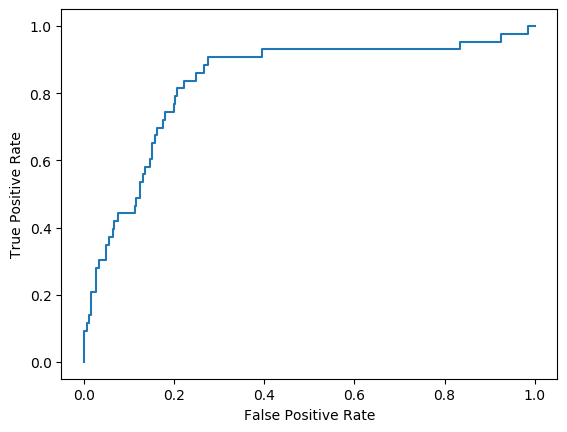

In [185]:
from sklearn import metrics
import matplotlib.pyplot as plt
#use model to predict probability that given y value is 1
y_pred_proba = logisticRegr.predict_proba(X_test)[::,1]

#calculate AUC of model
auc = metrics.roc_auc_score(Y_test, y_pred_proba)

#print AUC score
print(auc)

fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [187]:
metrics.confusion_matrix(Y_test, predictions)

array([[253,  13],
       [ 28,  15]])

## KNN

In [197]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=20)
neigh.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

0.7779332051057877


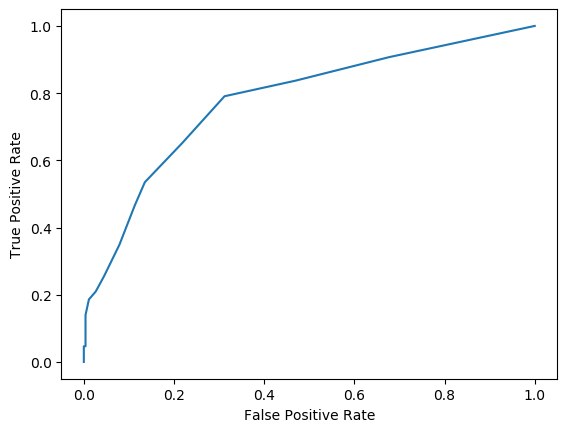

In [198]:


#use model to predict probability that given y value is 1
y_pred_proba = neigh.predict_proba(X_test)[::,1]

#calculate AUC of model
auc = metrics.roc_auc_score(Y_test, y_pred_proba)

#print AUC score
print(auc)

fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# Data Upload to S3

In [27]:
# Export to s3
bucket_export = 'clip-embedding-metastitch'
FILE_NAME  = 'contract_with_labels.csv'
contract_df.to_csv(FILE_NAME, index=False)
TO_DUMP = 'classifcation_v1/' + FILE_NAME
s3_client.upload_file(FILE_NAME, bucket_export, TO_DUMP)

In [28]:
embedings = glob('./feature_classification/*')
for file in embedings:
    file_name = file.split('/')[-1]
    TO_DUMP = 'classifcation_v1/features/' + file_name
    s3_client.upload_file(file, bucket_export, TO_DUMP)

In [29]:
import shutil
shutil.make_archive('feature_classification', 'zip', './feature_classification/')


'/root/feature_classification.zip'

In [30]:
s3_client.upload_file('feature_classification.zip', bucket_export, 'classifcation_v1/feature_classification.zip')